#  Анализ объявлений о продаже квартир (Авито, Москва)

Этот проект посвящён анализу данных с Avito о продаже квартир в Москве. Основные цели:

- Очистка и нормализация признаков,
- Удаление выбросов,
- Построение визуализаций,
- Конструирование признаков
- Получение выводов о факторах, влияющих на цену.


##  Предобработка и EDA

Перед анализом:
- Приведём площади, этажи и высоты к числовому формату,
- Выделим бинарные признаки (например, наличие мусоропровода),
- Преобразуем строковые значения метро в числовые (время до метро).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from ydata_profiling import ProfileReport
from preprocessing import run_pipeline

plt.style.use("ggplot")

In [ ]:
df = pd.read_csv(r"data\Авито _ Недвижимость _ Квартиры _ Купить _ Москва _ 2025-07-16 22_10_19 - Объявления.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1626 entries, 0 to 1625
Columns: 101 entries, Позиция to Unnamed: 100
dtypes: float64(4), int64(7), object(90)
memory usage: 1.3+ MB


In [4]:
df.describe()

,Позиция,Пр.Всего,Пр.Сегод.,Цена,Кол-во знак.,№ объяв.,Год постройки,Этажей в доме,Широта,Долгота,Фото шт.
count,1626.000000,1626.000000,1626.000000,1.626000e+03,1626.000000,1.626000e+03,1192.000000,1602.000000,1626.000000,1626.000000,1626.000000
mean,1268.539360,2089.579336,55.977245,2.381366e+07,985.787208,6.848676e+09,1988.005872,16.282772,55.737038,37.597020,16.637761
std,916.870228,8097.531546,141.824906,3.837704e+07,667.189137,1.303593e+09,28.789297,12.575988,0.089814,0.123676,9.416243
min,2.000000,0.000000,0.000000,1.500005e+06,12.000000,5.222793e+08,1828.000000,1.000000,55.501488,37.172116,1.000000
25%,469.250000,138.000000,7.000000,9.900000e+06,513.500000,7.287434e+09,1969.000000,9.000000,55.678169,37.511069,9.000000
50%,1061.500000,507.500000,16.000000,1.449950e+07,854.000000,7.440462e+09,1983.000000,14.000000,55.738913,37.596592,15.000000
75%,1986.750000,1551.250000,44.750000,2.359812e+07,1287.500000,7.502089e+09,2017.000000,19.000000,55.799775,37.668234,22.000000
max,3294.000000,205812.000000,2739.000000,5.500000e+08,7294.000000,7.565923e+09,2025.000000,95.000000,55.998700,37.949116,41.000000


In [5]:
df.columns

Index(['Позиция', 'Подкатегория', 'Заголовок', 'Пр.Всего', 'Пр.Сегод.', 'Цена',
       'Пониж.цена', 'Продвижения', 'Время поднятия', 'Описание',
       ...
       'Unnamed: 91', 'Unnamed: 92', 'Unnamed: 93', 'Unnamed: 94',
       'Unnamed: 95', 'Unnamed: 96', 'Unnamed: 97', 'Unnamed: 98',
       'Unnamed: 99', 'Unnamed: 100'],
      dtype='object', length=101)

In [6]:
#  Предварительная чистка
# Удаляем служебные или полностью пустые столбцы
df = df.loc[:, ~df.columns.str.contains("Unnamed")]
df = df.dropna(axis=1, thresh=len(df) * 0.5)  # Удаляем, если >50% NaN


## Извлечение числовой информации из столбцов, где она идет вместе с описанием.

С помощью функций выведем общую и жилую площадь, площадь кухни, количство этажей в доме и текущий этаж, количство комнат, минут до ближайшего метро.


In [7]:
def extract_number(text):
    """Извлекает первое число из строки (в т.ч. десятичное)"""
    if pd.isna(text):
        return np.nan
    match = re.search(r"\d+(\.\d+)?", str(text).replace('\xa0', ''))
    return float(match.group()) if match else np.nan

def clean_elevator(x):
    """Извлекает количество лифтов или возвращает 0, если 'нет'"""
    if pd.isna(x) or str(x).strip().lower() == 'нет':
        return 0
    match = re.search(r"\d+", str(x))
    return int(match.group()) if match else 1

def extract_minutes_avg(text):
    """Извлекает среднее число минут до метро (в т.ч. из диапазонов)"""
    if pd.isna(text):
        return np.nan
    text = str(text).replace('\xa0', ' ').replace('–', '-').replace('−', '-')
    numbers = re.findall(r"\d+", text)
    if not numbers:
        return np.nan
    numbers = list(map(int, numbers))
    return sum(numbers) / len(numbers)


def clean_room_count(val):
    """Извлекает количество комнат или возвращает 0, если студия, nan, если свободная планировка"""
    val_str = str(val).strip().lower()
    if "свободн" in val_str:
        return np.nan
    elif "студ" in val_str:
        return 0
    digits = [int(s) for s in val_str if s.isdigit()]
    return digits[0] if digits else np.nan


In [8]:


# Числовые извлечения из текстов
df['Общая площадь'] = df['Общая площадь'].apply(extract_number)
df['Жилая площадь'] = df['Жилая площадь'].apply(extract_number)
df['Площадь кухни'] = df['Площадь кухни'].apply(extract_number)
df['Высота потолков'] = df['Высота потолков'].apply(extract_number)
df['Пассажирский лифт'] = df['Пассажирский лифт'].apply(clean_elevator)
df['Грузовой лифт'] = df['Грузовой лифт'].apply(clean_elevator)

# Этаж / Этажность
etazh_split = df['Этаж'].str.extract(r'(\d+)\s*из\s*(\d+)', expand=True)
df['Этаж (текущий)'] = etazh_split[0].astype(float)
df['Этажей в доме'] = etazh_split[1].astype(float)


# Метро в минутах
df['Метро (минут)'] = df['Метро1'].apply(extract_minutes_avg)

#Количество комнат
df['Количество комнат'] = df['Количество комнат'].apply(clean_room_count)



In [9]:
# В стобцах способ продажи и вид сделки информация дублируется. Заполним отсуьствующие значения в стобце "Способ продажи" значениями стобца "Вид сделки"
df['Способ продажи'] = df['Способ продажи'].fillna(df['Вид сделки'])

In [10]:
#Удалим признаки, которые дублируются, не влияют на целевую перемнную, а также описания из которых уже были извлечены числовые значения. 
drop_list = ['Позиция', 'Этаж','Подкатегория', 'Заголовок', 'Пр.Всего', 'Пр.Сегод.','Пониж.цена',
         'Время поднятия', 'Описание', 'Кол-во знак.', '№ объяв.','Характеристики','Окна','Вид сделки',
          'Продавец', 'Адрес','Город', 'Метро1', 'Метро2', 'Метро3', 'Улица', 'Ссылка', 'Фото', 'Фото шт.']

## Удалим выбросы из наиболее значимых числовых характеристик с помощью IQR:
Будем использовать характеристики: 'Цена', 'Общая площадь', 'Жилая площадь'.

In [11]:
df = run_pipeline(df, outlier_columns_iqr=['Цена', 'Общая площадь'], columns_to_delete = drop_list)

[INFO] 🔄 Запуск пайплайна предобработки...
[INFO] Заполнены пропущенные значения в категориальных колонках: ['Подкатегория', 'Заголовок', 'Пониж.цена', 'Время поднятия', 'Описание', 'Характеристики', 'Этаж', 'Санузел', 'Окна', 'Ремонт', 'Способ продажи', 'Тип дома', 'Двор', 'Парковка', 'Тип комнат', 'Вид сделки', 'В доме', 'Продавец', 'Адрес', 'Город', 'Метро1', 'Метро2', 'Метро3', 'Улица', 'Ссылка', 'Фото']
[INFO] Заполнены пропуски: категориальные -> 'Unknown', числовые -> None
[INFO] Удаляем 24 неиспользуемых признаков: {'Пониж.цена', 'Адрес', 'Время поднятия', 'Описание', 'Этаж', 'Позиция', 'Улица', 'Ссылка', 'Продавец', 'Метро2', 'Вид сделки', 'Пр.Всего', 'Город', 'Пр.Сегод.', '№ объяв.', 'Окна', 'Метро1', 'Заголовок', 'Метро3', 'Фото шт.', 'Характеристики', 'Подкатегория', 'Фото', 'Кол-во знак.'}
[INFO] Удалено 170 выбросов по колонке 'Цена'
[INFO] Удалено 25 выбросов по колонке 'Общая площадь'
[INFO] Итого удалено 195 строк с выбросами
[INFO] ✅ Готово. Размер финального датасета

##  Визуализация

Построим графики:
- Распределения числовых признаков (гистограммы),
- Частоты категорий (тип дома, санузел),
- Boxplot по типу дома,
- Тепловая карта пропусков и корреляций.


In [12]:
df

,Год постройки,Парковка,Жилая площадь,Пассажирский лифт,Санузел,Способ продажи,Двор,Тип дома,Долгота,Цена,...,Количество комнат,Метро (минут),В доме,Ремонт,Этаж (текущий),Площадь кухни,Высота потолков,Широта,Этажей в доме,Общая площадь
0,1935.0,открытая во дворе,7.4,1,совмещенный,свободная,спортивная площадка,кирпичный,37.607664,3133000,...,0.0,8.0,Unknown,косметический,2.0,NaN,3.0,55.795929,5.0,14.8
1,1999.0,за шлагбаумом во дворе,18.8,1,совмещенный,свободная,"детская площадка, спортивная площадка",кирпичный,37.693615,16900000,...,1.0,13.0,Unknown,евро,2.0,8.0,2.8,55.773262,10.0,38.0
2,2024.0,подземная,NaN,1,совмещенный,свободная,"закрытая территория, детская площадка, спортив...",монолитно-кирпичный,37.458687,41500000,...,3.0,13.0,Unknown,требует ремонта,2.0,19.2,3.2,55.748853,19.0,86.7
5,1850.0,Unknown,14.0,0,совмещенный,свободная,Unknown,кирпичный,37.659838,5800000,...,0.0,8.0,Unknown,требует ремонта,1.0,NaN,3.0,55.746532,3.0,16.1
6,NaN,открытая во дворе,12.3,1,совмещенный,Unknown,"детская площадка, спортивная площадка",монолитный,37.302750,5600000,...,0.0,NaN,Unknown,Unknown,2.0,NaN,3.0,55.547760,17.0,22.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,1966.0,Unknown,NaN,0,Unknown,свободная,Unknown,монолитный,37.418721,12500000,...,2.0,5.0,Unknown,косметический,7.0,7.2,NaN,55.739063,12.0,38.8
1619,NaN,"подземная, открытая во дворе",NaN,2,раздельный,свободная,"детская площадка, спортивная площадка",монолитный,37.628239,19204000,...,2.0,13.0,консьерж,дизайнерский,18.0,20.0,NaN,55.651971,23.0,67.0
1620,1980.0,Unknown,15.0,0,совмещенный,свободная,Unknown,панельный,37.753038,8800000,...,1.0,13.0,Unknown,косметический,3.0,7.0,NaN,55.667376,9.0,27.1
1621,2023.0,подземная,NaN,2,"совмещенный, раздельный",свободная,"закрытая территория, детская площадка, спортив...",монолитный,37.509352,24500000,...,3.0,13.0,консьерж,требует ремонта,6.0,15.0,3.2,55.783221,23.0,69.0


In [13]:
df.isnull().sum()

Год постройки        362
Парковка               0
Жилая площадь        360
Пассажирский лифт      0
Санузел                0
Способ продажи         0
Двор                   0
Тип дома               0
Долгота                0
Цена                   0
Грузовой лифт          0
Тип комнат             0
Количество комнат      2
Метро (минут)          7
В доме                 0
Ремонт                 0
Этаж (текущий)         0
Площадь кухни        339
Высота потолков      539
Широта                 0
Этажей в доме          0
Общая площадь          0
dtype: int64

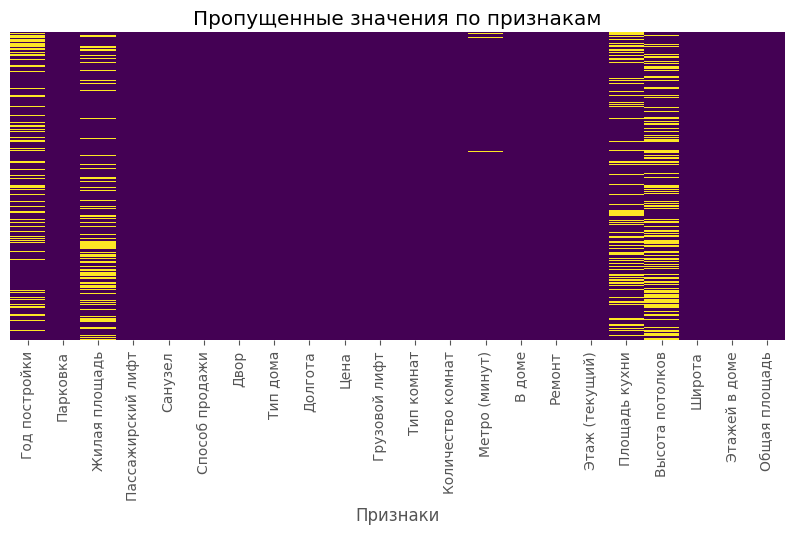

In [14]:


plt.figure(figsize=(10, 4))  # ширина и высота
sns.heatmap(df.isna(), 
            cmap='viridis', 
            cbar=False, 
            yticklabels=False)  # отключим метки Y
plt.title("Пропущенные значения по признакам")
plt.xlabel("Признаки")
plt.show()


In [15]:


def plot_feature_distributions(df, features, bins=30, cols_per_row=3):
    n_features = len(features)
    n_cols = cols_per_row
    n_rows = (n_features + n_cols - 1) // n_cols

    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        subplot_titles=[f"{col}" for col in features],
        horizontal_spacing=0.1,
        vertical_spacing=0.06
    )

    for i, col in enumerate(features):
        row = i // n_cols + 1
        col_pos = i % n_cols + 1

        fig.add_trace(
            go.Histogram(
                x=df[col].dropna(),
                nbinsx=bins,
                marker_color='indigo',
                showlegend=False,
                name=col
            ),
            row=row,
            col=col_pos
        )

        fig.update_xaxes(title_text=col, row=row, col=col_pos)
        fig.update_yaxes(title_text="Частота", row=row, col=col_pos)

    fig.update_layout(
        title="Распределения числовых признаков (по 3 на строку)",
        height= 350 * n_rows,
        width=1100,
        bargap=0.05
    )

    fig.show()

plot_feature_distributions(df, df.select_dtypes(include='number').columns)


Распределение признаков  Цена и Общая площадь стали более похожи на нормальное. Цена все же имеет тяжелый правый хвост, поэтому при построении модели регрессии нужно будет пролагоирмировать ее, чтобы сгладить распределение.

In [16]:
tlist = ['Цена', 'Общая площадь',
        'Год постройки', 'Количество комнат']

In [17]:
import plotly.express as px

# Выбираем нужные колонки и делаем выборку
sample_df = df[tlist].sample(1000)

# Создаем матрицу scatter plot
fig = px.scatter_matrix(
    sample_df,
    dimensions=tlist,
    title="Pairwise Relationships",
    height=1000,
    width=1000
)

# Настраиваем отображение диагонали (гистограммы)
fig.update_traces(diagonal_visible=True, 
                 showupperhalf=True, 
                 showlowerhalf=True)

# Настраиваем внешний вид
fig.update_layout(
    title_x=0.5,
    hovermode='closest'
)

fig.show()

## Анализ парных зависимостей
 - Цена имеет линейную зависимость с общей площадью. С остальными признаками цена имеет нелинейную зависимость.
 - Наиболшее количество продаваемых квартир имеют площадь от 37,5 до 42 кв.м и соответсвуют цене от 9 до 15 млн. руб
 - В структуре продаваемых квартир преобладают дома 2060-2075 годов постройки, а также 2010-2025.
 - Наиболее часто продают 2-ух комнатные квартиры, с площадью от 37 до 73 кв.м
 - Наиболее активно продаются  2-ух комнатные и 1 -комнатные квартиры периода постройки с 1960 по 1975 гг. Также 2-ух комнатные квартиры, построенные в период с 2010 по 2020 гг.
  


In [19]:
tlist = ['Цена', 'Общая площадь',
      'Год постройки', 'Этажей в доме']
def plot_features_on_map(data, features):
    for feature in features:
        fig = px.scatter(
            data_frame=data,
            x='Долгота',
            y='Широта',
            color=feature,
            title=f" Распределение признака: {feature}",
            color_continuous_scale='Plasma',
            opacity=0.7,
            labels={'Долгота': 'Долгота', 'Широта': 'Широта'}
        )
        fig.update_traces(marker=dict(size=5))
        fig.update_layout(height=600, width=1000)
        fig.show()


plot_features_on_map(df, tlist)

## Анализ географического распределения представленных квартир
 - Наиболее дешевые квартиры расположены в районах Новой Москвы
 - Преобладают квартиры в ценовом диапазоне от 12 до 16 млн. руб. Наибольшая часть данных квартир находится на Юге Москвы, а также на территории Новой Москвы


In [20]:


# Вычисляем корреляционную матрицу
corr_matrix = df.select_dtypes(include='number').corr(numeric_only=True)

# Тепловая карта с подписями
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    annotation_text=[[f"{val:.1f}" for val in row] for row in corr_matrix.values],
    colorscale='RdBu',
    showscale=True,
    zmin=-1, zmax=1
)

fig.update_layout(
    title=dict(
        text="Корреляции между числовыми признаками (контрастная палитра)",
        y=0.9999,  # выше
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=20)
    ),
    width=1300,
    height=900,
    margin=dict(l=150, r=50, t=150, b=200),
    xaxis=dict(tickangle=90)
)

fig.show()


## Анализ кмультиколлинераности переменных:
Заметим, что пары переменных Жилая площадь и Общая площадь,Количнство комнат и Жилая площадь имеют высокую мультиколлинеароность. Признаки количество комнат и общая жилая площадь несут в себе выокую информативность, удалить их без потери информативности не представляется возможным, поэтому объединим признками Жилая и Общая площадью.

In [21]:


# Расчёт корреляций
corr_df = df.select_dtypes(include='number').corr(numeric_only=True)['Цена'].sort_values(ascending=False)
corr_df = corr_df.drop('Цена')  # исключаем саму себя
corr_df = corr_df.reset_index().rename(columns={'index': 'Признак', 'Цена': 'Корреляция'})

# Визуализация на Plotly
fig = px.bar(
    corr_df,
    x='Признак',
    y='Корреляция',
    title=' Корреляция признаков с ценой',
    color='Корреляция',
    color_continuous_scale='RdBu'
)

fig.update_layout(
    xaxis_tickangle=90,
    yaxis=dict(title='Коэффициент корреляции'),
    title_font=dict(size=18),
    height=600
)
fig.show()


## Анализ корреляции с целевой переменной
 - Наибольшую корредяцию с целевой переменной, безусловно, имеют такие параметры как общая площадь, количество комнат и жилая площадь
 - Высота потолков мало влияет на целевую переменную, а также содержит большое количество отсутсвующих значений.
 - Широта и долготота по отдельности не сильно влияют на целевую переменную, поэтому необходимо добавить признак, который бы отражал принадлежность к определенному району, ожидается что данный признак должен будет внести больший вклад в модель

In [22]:
#Удалим столбец 'Высота потолков' т.к. он имеет слабую корреляцию с целевой переменной, а также большое количество отсуствующих значений:
df.drop('Высота потолков', axis =1, inplace=True)

# Конструирование признаков

### Сгенерируем дополнительные признаки - Расстояние до центра,  Район

In [23]:
#Применим k-means кластеринг для выделения 8 районов и добавление данного признака в модель
from sklearn.cluster import KMeans
coords = df[['Широта', 'Долгота']].values
kmeans = KMeans(n_clusters=8).fit(coords)
df['Район'] = kmeans.labels_

In [24]:
# Создадим признак расстояние до центра
center_lat, center_lon = 55.7558, 37.6176 # Координаты центра Москвы

# Евклидово расстояние 
df['Расстояние до центра'] = np.sqrt(
    (df['Широта'] - center_lat)**2 + 
    (df['Долгота'] - center_lon)**2
)

In [25]:
# Заменим признак жилая площадь на долю жилой в общей площади
df['Доля жилой площади'] = df['Жилая площадь']/df['Общая площадь']
df.drop('Жилая площадь', axis=1, inplace=True)

In [ ]:


# Переменные для boxplot'ов
cat_vars = [
    ('Тип дома', 'Цена', "Цена по типу дома"),
    ('Способ продажи', 'Цена', "Цена по способу продажи"),
    ('Тип дома', 'Общая площадь', "Общая площадь по типу дома"),
    ('Количество комнат', 'Общая площадь', "Общая площадь по количеству комнат")
]

# Цикл по переменным
for x_col, y_col, title in cat_vars:
    # Фильтрация unknown
    df_plot = df[df[x_col].astype('str').str.lower() != 'unknown']

    # Построение boxplot с Plotly
    fig = px.box(
        df_plot,
        x=x_col,
        y=y_col,
        title=title,
        points="outliers",  # отображение выбросов
        width=1000,
        height=600
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()


## Анализ цены и общей площади в разрезе категориальных признаков
- **Площадь и этажность** положительно коррелируют с ценой;
- В среднем, чем ближе к метро (меньше минут), тем выше цена — но корреляция умеренная;
- **Тип дома** — один из ключевых факторов. Монолит и кирпич — в среднем дороже;
- Указание санузла и лифта влияет на восприятие комфорта и цены;
- Цены на квартиры в домах, где есть консьерж и газ в среднем значительно превосходят цены в домах, где данных удобств нет 
- Квартиры с раздельным санузлом с среднем имеют более высокую стоимость, чем  квартиры с совмещенным с/у.
- Цены на квартиры, где есть ипотека в среднем значительно превосходят цены на квартры, с другим типом продажи
- Наиболшее количество продаваемых квартир имеют площадь от 37,5 до 42 кв.м и соответсвуют цене от 9 до 15 млн. руб
- В структуре продаваемых квартир преобладают дома 2060-2075 годов постройки, а также 2010-2025.
- Наиболее часто продают 2-ух комнатные квартиры.
- Наиболее активно продаются  2-ух комнатные и 1 -комнатные квартиры периода постройки с 1960 по 1975 гг. Также 2-ух комнатные квартиры, построенные в период с 2010 по 2020 гг.

In [27]:
result = df.groupby('Количество комнат')[['Общая площадь','Цена']].agg(['mean', 'median',  'min', 'max'])
# Форматируем все числовые колонки
result = result.style.format("{:.2f}")  # 2 знака после запятой
display(result)

## Анализ разброса квартир по количкству комнат, цене и общей площади.
 - Медианное значение общей площади студий  составляет 18 м.кв. Мы наблюдаем значительное количество выбросов в данной категории(тяжелый правый хвост), которое говорит, что на рынке имеются элитные предложения с увеличенной площалью или же со свободной планировкой. Вследствие чего средние и медианные значение цены и площади данных типов квартир значительно отличаются 
 - Однокомнатные квартиры имеют наибольший разброс по площади: на рынке есть предложения для эконом сегмента с минимальной площадью 15 кв.м., что скорее всего соответствует квартире студии, так и имеется большой пласт улучшенных вариантов, площадь которых выше чем медиання площадь двухкомнатных квартир.
 - У двухкомнатных квартир выбросы также, как и у студий сосредоточены в правой части.

## Обработка бинарных признаков

In [28]:
#  Обработка бинарных признаков (из строк)
# -----------------------------
# Признаки из 'В доме'
for feature in ['консьерж', 'мусоропровод', 'газ']:
    df[f"Есть {feature}"] = df['В доме'].apply(lambda x: int(pd.notna(x) and feature in x.lower()))

# Признаки из 'Двор'
df['Детская площадка'] = df['Двор'].apply(lambda x: int('детская' in str(x).lower()))
df['Спорт площадка'] = df['Двор'].apply(lambda x: int('спортивная' in str(x).lower()))
df['Закрытая территория'] = df['Двор'].apply(lambda x: int('закрытая' in str(x).lower()))

In [29]:
df.to_csv("avito_clean_final.csv", index=False)
print("Сохранено в avito_clean_final.csv")

Сохранено в avito_clean_final.csv


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1431 entries, 0 to 1624
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Год постройки         1069 non-null   float64
 1   Парковка              1431 non-null   object 
 2   Пассажирский лифт     1431 non-null   int64  
 3   Санузел               1431 non-null   object 
 4   Способ продажи        1431 non-null   object 
 5   Двор                  1431 non-null   object 
 6   Тип дома              1431 non-null   object 
 7   Долгота               1431 non-null   float64
 8   Цена                  1431 non-null   int64  
 9   Грузовой лифт         1431 non-null   int64  
 10  Тип комнат            1431 non-null   object 
 11  Количество комнат     1429 non-null   float64
 12  Метро (минут)         1424 non-null   float64
 13  В доме                1431 non-null   object 
 14  Ремонт                1431 non-null   object 
 15  Этаж (текущий)        1431

In [31]:
df.head()

,Год постройки,Парковка,Пассажирский лифт,Санузел,Способ продажи,Двор,Тип дома,Долгота,Цена,Грузовой лифт,...,Общая площадь,Район,Расстояние до центра,Доля жилой площади,Есть консьерж,Есть мусоропровод,Есть газ,Детская площадка,Спорт площадка,Закрытая территория
0,1935.0,открытая во дворе,1,совмещенный,свободная,спортивная площадка,кирпичный,37.607664,3133000,1,...,14.8,4,0.041341,0.500000,0,0,0,0,1,0
1,1999.0,за шлагбаумом во дворе,1,совмещенный,свободная,"детская площадка, спортивная площадка",кирпичный,37.693615,16900000,1,...,38.0,4,0.077995,0.494737,0,0,0,1,1,0
2,2024.0,подземная,1,совмещенный,свободная,"закрытая территория, детская площадка, спортив...",монолитно-кирпичный,37.458687,41500000,1,...,86.7,6,0.159065,NaN,0,0,0,1,1,1
5,1850.0,Unknown,0,совмещенный,свободная,Unknown,кирпичный,37.659838,5800000,0,...,16.1,5,0.043243,0.869565,0,0,0,0,0,0
6,NaN,открытая во дворе,1,совмещенный,Unknown,"детская площадка, спортивная площадка",монолитный,37.302750,5600000,1,...,22.3,6,0.377374,0.551570,0,0,0,1,1,0


##  Выводы по данным

- **Площадь и этажность** положительно коррелируют с ценой;
- В среднем, чем ближе к метро (меньше минут), тем выше цена — но корреляция умеренная;
- **Тип дома** — один из ключевых факторов. Монолит и кирпич — в среднем дороже;
- Указание санузла и лифта влияет на восприятие комфорта и цены;
- Цены на квартиры в домах, где есть консьерж и газ в среднем значительно превосходят цены в домах, где данных удобств нет 
- Квартиры с раздельным санузлом с среднем имеют более высокую стоимость, чем  квартиры с совмещенным с/у.
- Цены на квартиры, где есть ипотека в среднем значительно превосходят цены на квартры, с другим типом продажи



